In [1]:
#! pip install tensorflow==1.15.0
#! pip install keras==2.2.4

You should consider upgrading via the 'pip install --upgrade pip' command.
You should consider upgrading via the 'pip install --upgrade pip' command.


In [2]:
import tensorflow as tf
import keras
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

from keras.preprocessing.sequence import pad_sequences
from keras.models import Model, Input
from keras.layers import LSTM, Embedding, Dense, TimeDistributed, Dropout, Bidirectional
from keras_contrib.layers import CRF

Using TensorFlow backend.


In [3]:
print("Tensorflow version: ", tf.__version__)
print("Keras version: ", keras.__version__)

Tensorflow version:  1.15.0
Keras version:  2.2.4


In [4]:
# Hyperparams
BATCH_SIZE = 512  # Number of examples used in each iteration
EPOCHS = 5  # Number of passes through entire dataset
MAX_LEN = 80  # Max length of review (in words)
EMBEDDING = 200  # Dimension of word embedding vector

In [11]:
def transform_dataset(fileName):
  f_new = open("updated_" + fileName,"w")
  f = open(fileName, "r")
  sentenceNumber = 1
  writeLineNumber = True
  for x in f:
    if x == "\n":
      sentenceNumber = sentenceNumber + 1
    else:
      x_list = x.split(" ")
      # uncomment the below block if you only want to train the model for Noun Phrase.
      '''if x_list[-1] not in ["B-NP\n", "I-NP\n"]:
        x_list[-1] = "O\n"'''
      x_new = " ".join(x_list)
      f_new.write("Sentence:" + str(sentenceNumber) + " " + x_new )
  return(sentenceNumber-1) # the file ends with a \n


print("Number of Training sentences:\t", transform_dataset("train.txt"))
print("Number of Testing sentences:\t", transform_dataset("test.txt"))
# open updated_train.txt and updated_test.txt to see the format to which it has been transformed.

Number of Training sentences:	 8936
Number of Testing sentences:	 2012


In [13]:
data = pd.read_csv('updated_train.txt', sep=" ", header=None)
data = data.fillna(method="ffill")

data.columns = ["sentence#", "word", "ner", "chunk"]

words = list(set(data["word"].values))
n_words = len(words)
print("Number of words in the training dataset:\t" + str(n_words))
tags = list(set(data["chunk"].values))
n_tags = len(tags)
print("Number of tags in the training dataset:\t", n_tags)
print("The tags are ", tags)

Number of words in the training dataset:	19122
Number of tags in the training dataset:	 22
The tags are  ['I-NP', 'B-CONJP', 'I-UCP', 'I-VP', 'I-ADJP', 'I-SBAR', 'O', 'B-VP', 'I-PP', 'I-INTJ', 'I-CONJP', 'B-NP', 'B-PP', 'B-ADJP', 'B-ADVP', 'B-LST', 'B-INTJ', 'I-PRT', 'B-PRT', 'B-UCP', 'B-SBAR', 'I-ADVP']


In [14]:
data_test = pd.read_csv('updated_test.txt', sep=" ", header=None)
data_test = data_test.fillna(method="ffill")

data_test.columns = ["sentence#", "word", "ner", "chunk"]

words_test = list(set(data_test["word"].values))
n_words_test = len(words_test)
print("Number of words in the testing dataset: " + str(n_words_test))
tags_test = list(set(data_test["chunk"].values))
n_tags_test = len(tags_test)
print("Number of tags in the testing dataset: ", n_tags_test)
print("The tags are ", tags_test)

Number of words in the testing dataset: 8118
Number of tags in the testing dataset:  19
The tags are  ['I-NP', 'B-NP', 'B-PP', 'B-INTJ', 'B-LST', 'I-ADJP', 'I-LST', 'I-SBAR', 'B-ADJP', 'B-PRT', 'B-CONJP', 'O', 'B-ADVP', 'B-VP', 'B-SBAR', 'I-PP', 'I-ADVP', 'I-VP', 'I-CONJP']


8936


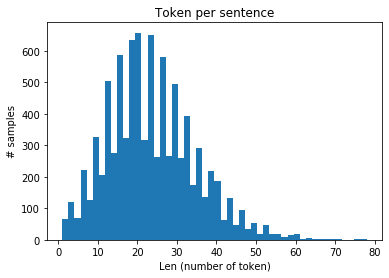

In [15]:
class SentenceGetter(object):
    """Class to Get the sentence in this format:
    [(Token_1, Part_of_Speech_1, Tag_1), ..., (Token_n, Part_of_Speech_1, Tag_1)]"""
    def __init__(self, data):
        """Args:
            data is the pandas.DataFrame which contains the above dataset"""
        self.n_sent = 1
        self.data = data
        self.empty = False
        agg_func = lambda s: [(w, p, t) for w, p, t in zip(s["word"].values.tolist(),
                                                           s["ner"].values.tolist(),
                                                           s["chunk"].values.tolist())]
        self.grouped = self.data.groupby("sentence#", sort=False).apply(agg_func)
        #self.grouped.sort_values('sentence#', ascending=True)

        self.sentences = [s for s in self.grouped]
    
    def get_next(self):
        """Return one sentence"""
        try:
            s = self.grouped["Sentence: {}".format(self.n_sent)]
            self.n_sent += 1
            return s
        except:
            return None

getter = SentenceGetter(data)
sent = getter.get_next()
sentences = getter.sentences

print(len(sentences))
plt.hist([len(s) for s in sentences], bins=50)
plt.title('Token per sentence')
plt.xlabel('Len (number of token)')
plt.ylabel('# samples')
plt.show()

In [16]:
getter_test = SentenceGetter(data_test)
sent_test = getter_test.get_next()

sentences_test = getter_test.sentences

In [17]:
# Vocabulary Key:word -> Value:token_index
# The first 2 entries are reserved for PAD and UNK
word2idx = {w: i + 2 for i, w in enumerate(words)}
word2idx["UNK"] = 1 # Unknown words
word2idx["PAD"] = 0 # Padding
# Vocabulary Key:token_index -> Value:word
idx2word = {i: w for w, i in word2idx.items()}
print("The word commitment is identified by the index: {}".format(word2idx["Confidence"]))

The word commitment is identified by the index: 8441


In [18]:
# Vocabulary Key:Label/Tag -> Value:tag_index
# The first entry is reserved for PAD
tag2idx = {t: i+1 for i, t in enumerate(tags)}
tag2idx["PAD"] = 0
# Vocabulary Key:tag_index -> Value:Label/Tag
idx2tag = {i: w for w, i in tag2idx.items()}
print("The labels B-NP is identified by the index: {}".format(tag2idx["B-NP"]))

The labels B-NP is identified by the index: 12


In [19]:
# Convert each sentence from list of Token to list of word_index
X_tr= [[word2idx[w[0]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
X_tr = pad_sequences(maxlen=MAX_LEN, sequences=X_tr, padding="post", value=word2idx["PAD"])
print(type(X_tr[0]))
# Convert Tag/Label to tag_index
y_tr = [[tag2idx[w[2]] for w in s] for s in sentences]
# Padding each sentence to have the same lenght
y_tr = pad_sequences(maxlen=MAX_LEN, sequences=y_tr, padding="post", value=tag2idx["PAD"])

from keras.utils import to_categorical
# One-Hot encode
y_tr = [to_categorical(i, num_classes=n_tags+1) for i in y_tr]  # n_tags+1(PAD)

X_te = []

for s in sentences_test:
    temp = []
    for w in s:
        if w[0] in word2idx:
            temp.append(word2idx[w[0]])
        else:
            temp.append(word2idx["UNK"])
    temp = np.array(temp)
    X_te.append(temp)

    
X_te = np.array(X_te)
#X_te = [[word2idx[w[0]] for w in s] for s in sentences_test]
X_te = pad_sequences(maxlen=MAX_LEN, sequences=X_te, padding="post", value = word2idx["PAD"])

y_te = []

for s in sentences_test:
    temp = []
    for w in s:
        if w[2] in tag2idx:
            temp.append(tag2idx[w[2]])
        else:
            temp.append(tag2idx["O"])
    #temp = np.array(temp)
    y_te.append(temp)
    
#y_te = [[tag2idx[w[2]] for w in s] for s in sentences_test]
# Padding each sentence to have the same lenght
y_te = pad_sequences(maxlen=MAX_LEN, sequences=y_te, padding="post", value=tag2idx["PAD"])
y_te = [to_categorical(i, num_classes=n_tags+1) for i in y_te]  # n_tags+1(PAD)

print('Raw Sample: ', ' '.join([w[0] for w in sentences_test[0]]))
print('Raw Label: ', ' '.join([w[2] for w in sentences_test[0]]))
print('After processing, sample:', X_tr[0])
print('After processing, labels:', y_tr[0])

<class 'numpy.ndarray'>
Raw Sample:  Rockwell International Corp. 's Tulsa unit said it signed a tentative agreement extending its contract with Boeing Co. to provide structural parts for Boeing 's 747 jetliners .
Raw Label:  B-NP I-NP I-NP B-NP I-NP I-NP B-VP B-NP B-VP B-NP I-NP I-NP B-VP B-NP I-NP B-PP B-NP I-NP B-VP I-VP B-NP I-NP B-PP B-NP B-NP I-NP I-NP O
After processing, sample: [ 8441  1435 17095 17882 17075  2073  8335 17649  5540 14390 18133  2352
 16452  4626  2081   363  5815 13860  5408   363  7352  3429 13860  9347
 17649 15744 11471 11726 13430 13743 16656  2078 17421  7125  8334 10037
 13680     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0     0     0     0     0
     0     0     0     0     0     0     0     0]
After processing, labels: [[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [1. 0. 0. ... 0.

In [20]:
# Model definition
input = Input(shape=(MAX_LEN,))
model = Embedding(input_dim=n_words+2, output_dim=EMBEDDING, # n_words + 2 (PAD & UNK)
                  input_length=MAX_LEN, mask_zero=True)(input)  # default: 20-dim embedding
model = Bidirectional(LSTM(units=50, return_sequences=True,
                           recurrent_dropout=0.1))(model)  # variational biLSTM
model = TimeDistributed(Dense(50, activation="relu"))(model)  # a dense layer as suggested by neuralNer
crf = CRF(n_tags+1)  # CRF layer, n_tags+1(PAD)
out = crf(model)  # output

model = Model(input, out)
model.compile(optimizer="rmsprop", loss=crf.loss_function, metrics=[crf.accuracy])

model.summary()





Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where



/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:346: UserWarning: CRF.loss_function is deprecated and it might be removed in the future. Please use losses.crf_loss instead.
  warnings.warn('CRF.loss_function is deprecated '
/usr/local/lib/python3.6/dist-packages/keras_contrib/layers/crf.py:353: UserWarning: CRF.accuracy is deprecated and it might be removed in the future. Please use metrics.crf_accuracy
  warnings.warn('CRF.accuracy is deprecated and it '


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 80)                0         
_________________________________________________________________
embedding_1 (Embedding)      (None, 80, 200)           3824800   
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 100)           100400    
_________________________________________________________________
time_distributed_1 (TimeDist (None, 80, 50)            5050      
_________________________________________________________________
crf_1 (CRF)                  (None, 80, 23)            1748      
Total params: 3,931,998
Trainable params: 3,931,998
Non-trainable params: 0
_________________________________________________________________


In [21]:
history = model.fit(X_tr, np.array(y_tr), batch_size=BATCH_SIZE, epochs=20, verbose=2)




Epoch 1/20





 - 11s - loss: 14.3715 - crf_viterbi_accuracy: 0.2419
Epoch 2/20
 - 10s - loss: 13.6363 - crf_viterbi_accuracy: 0.3854
Epoch 3/20
 - 9s - loss: 13.2868 - crf_viterbi_accuracy: 0.5237
Epoch 4/20
 - 9s - loss: 12.8571 - crf_viterbi_accuracy: 0.7205
Epoch 5/20
 - 9s - loss: 12.5485 - crf_viterbi_accuracy: 0.8109
Epoch 6/20
 - 9s - loss: 12.3678 - crf_viterbi_accuracy: 0.8604
Epoch 7/20
 - 10s - loss: 12.2589 - crf_viterbi_accuracy: 0.8883
Epoch 8/20
 - 9s - loss: 12.1865 - crf_viterbi_accuracy: 0.9050
Epoch 9/20
 - 9s - loss: 12.1355 - crf_viterbi_accuracy: 0.9185
Epoch 10/20
 - 9s - loss: 12.0983 - crf_viterbi_accuracy: 0.9283
Epoch 11/20
 - 9s - loss: 12.0675 - crf_viterbi_accuracy: 0.9370
Epoch 12/20
 - 9s - loss: 12.0415 - crf_viterbi_accuracy: 0.9438
Epoch 13/20
 - 9s - loss: 12.0237 - crf_viterbi_accuracy: 0.9483
Epoch 14/20
 - 9s - loss: 12.0056 - crf_viterbi_accuracy: 0.9538
Epoch 15/20
 - 9s - loss: 11.9927 - crf_viterbi_accuracy: 0.9571
Epoch 16/20
 - 9s - los

In [22]:
pred_cat = model.predict(X_te)
pred = np.argmax(pred_cat, axis=-1)
y_te_true = np.argmax(y_te, axis=-1)

In [23]:
def writeToPredictedFile():
    f_new = open("predicted_test.txt","w")
    count = 0
    print("Writing ", len(sentences_test), " sentences")
    for index,s in enumerate(sentences_test):
        for word_index, word in enumerate(s):
            #print(word)
            f_new.write(word[0] + " " + word[1] + " " + idx2tag[pred[index][word_index]] + "\n")
            count = count + 1
        f_new.write("\n")
        count = count + 1
    print(count)
writeToPredictedFile()

Writing  2012  sentences
49389


Now that we have obtained the predicted tags in BIO format, we will aggregate the results and find the F score on the NPs.

In [24]:
def createNPs(fileName):
    with open(fileName) as fp:
        line = fp.readline()
        count = 0
        sentenceList = []
        sentCount = 0
        NPstarted = False
        NPList = []
        listWithWordAndPhraseTag = []
        sentenceLevelListWithWordAndPhraseTag = []
        sentence = ""
        runningNP = ""
        while line:
            lineList = line.split(" ")
            if line.strip() == "":
                if runningNP != "":
                    NPList.append(runningNP)

                tempObj = {"sentence" : sentence.strip(), "NPList" : copy.deepcopy(NPList)}
                sentenceList.append(tempObj)
                sentCount = sentCount + 1
                NPstarted = False
                NPList = []
                runningNP = ""
                sentence = ""
                line = fp.readline()
                listWithWordAndPhraseTag.append(copy.deepcopy(sentenceLevelListWithWordAndPhraseTag))
                sentenceLevelListWithWordAndPhraseTag = []
                count = count + 1
                continue

            word = lineList[0]
            POS = lineList[1]
            POS = POS.strip()
            NP = lineList[2]
            NP = NP.strip()
            sentenceLevelListWithWordAndPhraseTag.append([word, NP])
            if NP == "B-NP" and NPstarted == False:
                #print("came here")
                NPstarted = True
                runningNP = word
            else:
                if NPstarted == True and (NP == "I-NP" or (NP == "B-NP" and POS == "POS")):
                    #print("came here ")
                    if POS == "POS" or POS == "." or POS == ",":
                        runningNP = runningNP + word
                    else:
                        runningNP = runningNP + " " + word

                elif NPstarted == True and NP != "I-NP":
                    #print("came in elif")
                    NPstarted = False
                    NPList.append(runningNP.strip())
                    runningNP = ""
                    if NP == "B-NP":
                        NPstarted = True
                        runningNP = word

            if POS == "POS" or POS == "." or POS == ",":
                sentence = sentence + word
            else:
                sentence = sentence + " " + word

            count = count + 1
            line = fp.readline()
        print("Processed ", count, " lines")
        return (listWithWordAndPhraseTag, sentenceList)

In [25]:
listWithWordAndPhraseTag_ground, sentenceList_ground = createNPs("test.txt")

Processed  49389  lines


In [26]:
listWithWordAndPhraseTag_eval, sentenceList_eval = createNPs("predicted_test.txt")

Processed  49389  lines


In [27]:
print(len(sentenceList_ground), len(sentenceList_eval))
assert len(sentenceList_ground) == len(sentenceList_eval)

2012 2012


In [28]:
totalChunksGroundTruth = 0
totalChunksPredicted = 0
totalCorrectChunksPredicted = 0
deviations = []

In [29]:
for index,item in enumerate(sentenceList_ground):
    NPList_ground = item["NPList"]
    NPList_eval = sentenceList_eval[index]["NPList"]
    totalChunksGroundTruth = totalChunksGroundTruth + len(NPList_ground)
    totalChunksPredicted = totalChunksPredicted + len(NPList_eval)
    
    for predictedNP in NPList_eval:
        if predictedNP in NPList_ground:
            totalCorrectChunksPredicted = totalCorrectChunksPredicted + 1
    
    if NPList_ground != NPList_eval:
        deviations.append(index)
        

In [30]:
precision = (totalCorrectChunksPredicted/totalChunksPredicted)*100
print("Precision: \t" + str(precision))

recall = (totalCorrectChunksPredicted/totalChunksGroundTruth)*100
print("Recall: \t" + str(recall))

FScore = 2 * ((precision * recall)/(precision + recall))
print("F Score: \t" + str(FScore))

Precision: 	86.6644412918301
Recall: 	86.60662163289133
F Score: 	86.63552181529991


In [ ]:
# Print the below line if you want a list of indexes of sentences that have deviated from the ground truth.
# You can use this to analyze sentences as done in the next block.
#print(deviations)

In [ ]:
# in testIndex, feed the index of a sentence that you would like to evaluate.
testIndex = 2
print("Ground Truth:")
print(sentenceList_ground[testIndex]["NPList"])

print("Predicted:")
print(sentenceList_eval[testIndex]["NPList"])

# Fine grained evaluation of the tags assigned.

This part is optional and charts out the fine grained accuracies of the labels. You could use this to obtain a finer understanding of which tags have not been predicted correctly the most times and other analysis that could help you better the model.

In [ ]:
#! pip -q install git+https://www.github.com/keras-team/keras-contrib.git sklearn-crfsuite

In [ ]:
'''from sklearn_crfsuite.metrics import flat_classification_report

# Convert the index to tag
pred_tag = [[idx2tag[i] for i in row] for row in pred]
y_te_true_tag = [[idx2tag[i] for i in row] for row in y_te_true] 

report = flat_classification_report(y_pred=pred_tag, y_true=y_te_true_tag)
print(report)'''